# Import:
1. import os library for collecting the text files.
2. import string and nltk for tokenizing the files.

We use nltk to find the stem of each term and also find every stopword in english.

In [1]:
import os
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Get files:

In this cell we use os library to get the text files in current directory. Then return the document's names and their contents.

In [2]:
def get_text_files():
    
    current_directory = os.getcwd()

    # List all files in the current directory
    file_list = os.listdir(current_directory)

    # Filter the list to include only text files (if needed)
    text_files = [file for file in file_list if file.endswith('.txt')]

    # This is where we keep our documents
    documents = []

    # Loop through each text file and open/read them
    for i in range(len(text_files)):
        file_name = text_files[i]
        file_path = os.path.join(current_directory, file_name)
        
        # Open and read the file
        with open(file_path, 'r') as file:
            documents.append(file.read())
    
    return text_files, documents

# Tokenize:

In this cell, every text files, convert to a list whitout any puntuation and stop word.

1. Punctuation are not important at all, so removing them helps the document retreival.
2. Removing stop words is important beacuse they don't add much value to a text and make our search more sufficient and faster.
3. Also we convert every character to it's lower case. And we do the same with query So that makes search and comparing more easy.
4. And store each term stem instead of the term itself.

In [3]:
def tokenize(documents):
    # Set the stop words for English
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    # This is the final list of tokenized text in lists
    tokenized_list = []
    
    # For each document, we use nltk regex_tokenize to token all the text file
    for doc in documents:
        tokenized_text =  nltk.regexp_tokenize(doc, r'\d+,\d+|\w+')
        
        # Here we handle ',' in the numbers (beacuse nltk doesn't handle this)
        for i in range(len(tokenized_text)):
            if ',' in tokenized_text[i]:
                w = ''
                for c in tokenized_text[i]:
                    if c != ',':
                        w += c 
                    tokenized_text[i] = w
        
        # Then remove any punctuation and store the stem of each term
        text_without_punctuation = [porter.stem(word) for word in tokenized_text if word.isalnum()]
        
        # And remove the stop words cause they don't add much to a text
        text_without_stop_words = [word for word in text_without_punctuation if word not in stop_words]
        
        tokenized_list.append(text_without_stop_words)
    return tokenized_list

# Get ID:
This function is used to find out the ID of last document added to the string. It gets a string of gamma code for documnet ID's after each other (gaps are stored to use less space) and find the last documnet ID that has been added to the string.

1. There is a "doc_id" variable which will have the last document ID when this function terminates.
2. And there is a "while" which iterates on the string to calculate the ID we want.
3. Length part: In this part, everytime we count the number of 1's so that we can determine the offset later.
4. Offset part: In this part, we calculate the value that has been stored in "length" characters based on $\gamma$-code.
5. There is a case which we might meet a single 0 for $\gamma$-code, this case means that the value stored in that part is equal to 1.

In [4]:
def to_id(s):
    # doc_id will be the last ID stored in string
    doc_id = 0
    # We use i to iterate over string s
    i = 0
    
    # length_part is when we are still counting the 1's
    length_part = 1
    
    # offset_part is when we are calculating the stored value in that part
    offset_part = 0
    
    # It is used to store the number of 1's in each code
    length = 0

    while(i < len(s)):
        # Count the number of 1's and then change the situation to offset_part if catch up a 0
        if length_part:
            if s[i] == "1":
                length += 1
            else:
                length_part = 0
                offset_part = 1
            i += 1
        
        # If only a 0 is stored in that part which means a value of 1
        if length == 0 and offset_part:
            doc_id += 1
            offset_part = 0
            length_part = 1
                
        # Calculate the value store in that part
        elif offset_part:
            # num will be the decimal value of the offset stored
            num = 2**length
            for j in range(length-1, -1, -1):
                num += (s[i] == "1")*2**j
                i += 1
            # Change to length_part
            offset_part = 0
            length_part = 1
            length = 0
            doc_id += num
    
    return doc_id

# Get $\gamma$-code:

In this function, we find the $\gamma$-code representation of a given number.
1. First we store the binary representation of num in binary.
2. Then add n-1 1's at the front of string.
3. Drop the first 1 in binary representation and return the string of $\gamma$-code.

In [5]:
def to_code(num):
    # Find out the gamma-code of num
    binary = ""
    # Calculate the binary representation of num
    while num > 0:
        binary = str(num%2) + binary
        num = num//2
    # Create gamma-code
    return "1"*(len(binary)-1) + "0" + binary[1:]

# Concatenate $\gamma$-codes:

This function is used to concatenate an ID to a given string.
1. If s is empty: We have to find the code for given ID and that would be our result.
2. Otherwise, We use the to_id function to get the last ID in string s.
3. Then find the gap between last ID and given ID.
4. Then find the $\gamma$-code to the gap and add it to the string if it is a new document (gap is greater than zero).

In [6]:
def gamma_code_connect(s, doc_id):
    # This function is used to concatenate an ID to a given string
    # If s is empty
    if len(s) == 0:
        s = to_code(doc_id)
    
    else:
        last_id = to_id(s)
        # Find the gap between last ID in s and given ID
        gap = doc_id - last_id
        # If it is a new document, add it to the s
        if gap:
            s += to_code(gap)

    return s        

# Inverted Index:

In this function, we calculate the inverted index for each block and return the dictionary.

For each term in each document:
1. If it is a new term in current dictionary. We use gamma_code_connect with the empty string to find the code.
2. Otherwise, we use the same function with string equal to the string for that term in dictionary.
3. And then update the value of that term in the dictionary.

In [7]:
def inverted_index(documents, tokenized_list):
    # This is the dictionary for inverted index that we will construct
    dictionary = dict()

    # Iterate over documents given
    for i in range(len(documents)):
        doc_id = documents[i]
        # Iterate over terms in a document
        for token_index in range(len(tokenized_list[i])):
            term = tokenized_list[i][token_index]
            
            if term in dictionary: # Checking if the term is already in the dictionary and then add it to the rest
                dictionary[term] = gamma_code_connect(dictionary[term], doc_id)
                
            else: # If this is a new term
                dictionary[term] = gamma_code_connect("", doc_id)
    return dictionary

# Merge:

In this function, we get a list of dictionaries and merge them.
1. First of all, the final dictionary will be equal to first dictionary in the list.
2. then for keys in each dictionary,
3. If the key is new, we add it to final dictionary with the same key.
4. If the key is already in the dictionary, first divide the new value to the first $\gamma$-code and the rest.
5. then find the ID to the first code (we have to convert this code to it's gap from the last ID already in the dictionary).
6. Finally use the gamma_code_connect to concatenate the $\gamma$-codes.

In [8]:
def merge_inverted_index(dicts):
    # A function to merge dictionaries in dicts
    # First, final dict is equal to first dict
    final_dict = dicts[0]
    
    # For each key in the rest of dicts
    for dictionary in dicts[1:]:
        for key in list(dictionary.keys()):
            # If it is a new term for final dict
            if key not in final_dict:
                final_dict[key] = dictionary[key]
            # If it is not new, create the new string for gamma codes
            else:
                new_code = dictionary[key]

                i = 0
                while new_code[i] == "1":
                    i += 1
                index = 2*i
                
                # divide the new string to first gamma code and rest
                first = new_code[:index+1]
                rest = new_code[index+1:]
                
                # Find the doc ID to first gamma code
                doc_id = to_id(first)
                # Concatenate the codes
                final_dict[key] = gamma_code_connect(final_dict[key], doc_id) + rest
    return final_dict

# Main:
1. First we get the documents.
2. Then create the tokenized lists.
3. Then we assume we have blocks with 3 documents each.
4. Create the inverted index for each block.
5. merge all inverted indexes.

In [9]:
# Get data
text_files, documents = get_text_files()
# Tokenize
tokenized_list = tokenize(documents)

# Create inverted index, block by block
dicts = []
for i in range(0, len(documents), 3):
    dicts.append(inverted_index([j for j in range(i+1, i+4)], tokenized_list[i:i+3]))

# Merge all dictionaries
dictionary = merge_inverted_index(dicts)

This is the final dictionary:

As we can see, there is a string as a value for each key. The string is showing the $\gamma$-codes after each other. The first $\gamma$-code is the representation for the first document ID, the code after that, is showing the gap between second document ID and the first one. And the third code is representing the gap between third and second document ID.

For example, we have '0011010011000100' for 'peopl':
1. 0 is representing for document with ID 1.
2. 0 is showing the gap with size 1, so the second ID is equal to 2.
3. 11010 is showing the gap with size 6, so the next ID is equal to 8.
4. 0 is showing the gap size 1 from 8, so the ID is 9.
5. 11000 is showing the gap size 4, next ID will be 13.
6. 100 is representing 2, so the last ID is equal to 15.

So the document ID's that peopl stem has appeared in are:
$${1, 2, 8, 9, 13, 15}$$
P.S: The ID's are 1 base ($ID = 1, 2, \dots, 15$)

In [10]:
dictionary

{'peopl': '0011010011000100',
 'joke': '0',
 'one': '0001001001000000100',
 'lo': '011010',
 'angel': '011010',
 'read': '0',
 'everyon': '01100011011100',
 'watch': '01100011001100',
 'tv': '01001110001',
 'rent': '0111000011000',
 'video': '01110001',
 'goe': '0101011000',
 'movi': '01110001',
 'popular': '011001',
 'materi': '0',
 'comic': '0',
 'book': '011010',
 'magazin': '0110010',
 'guid': '0',
 'citi': '01110100',
 'librari': '0',
 'onli': '0100110000000100',
 '10': '0110001011001010',
 'percent': '0110000100011000100',
 'traffic': '01101111011',
 'car': '0100110000010100',
 'wash': '01110010',
 'explain': '0',
 'thi': '0100010010011001100',
 'annual': '01110000',
 'festiv': '0',
 'west': '011010',
 'sold': '011000',
 'year': '0000010000000000',
 'wait': '010111000101',
 'half': '0010010011010',
 'hour': '010011000100101',
 'park': '01101011010',
 'space': '0',
 'becom': '0',
 'avail': '0',
 'outdoor': '0',
 'sponsor': '0',
 'newspap': '011010',
 'occur': '001110010',
 'everi'

This is a test for people from miniProject1. As we can see, the results are the same.

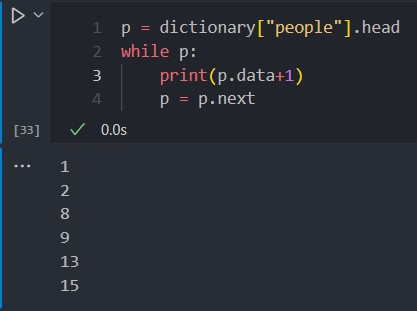

In [11]:
from PIL import Image
from IPython.display import display
image_path = "test-people.jpg"
image = Image.open(image_path)
display(image)